# Resnet50  : Residual Network on Custom Dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf


In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import scipy.misc
from matplotlib.pyplot import imshow

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

# Identity Block

In [4]:
# x is input, y=F(x)
# identity block simply means input should be equal to output. 
#  y = x + F(x)   the layers in a traditional network are learning the true output H(x)
# F(x) = y - x   the layers in a residual network are learning the residual F(x)
# Hence, the name: Residual Block.



def identity_block(X, f, filters, stage, block):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

# Convolutional Block

In [5]:

def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


# Creating ResNet 50 

In [6]:
#Each ResNet block is either 2 layer deep
def ResNet50(input_shape=(64, 64, 3)):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)

   
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 

  
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    ### START CODE HERE ###

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)

    X = Dense(1,activation='relu',  name='output')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


# For metacarpal training

In [7]:
# model_carpal = ResNet50(input_shape = (224, 224, 3))
# model_metacarpal = ResNet50(input_shape = (224, 224, 3))
# model_metacarpal.load_weights('./saved_weights/resnet/metacarpal_weights_130_epoch.h5')
# model_carpal.load_weights('./saved_weights/resnet/carpal_weights_50_epoch.h5')
model = ResNet50(input_shape = (224, 224, 3))


In [8]:
from keras.optimizers import Adam
optim = Adam(
    learning_rate = 0.00001,
    beta_1 = 0.9,
    beta_2 = 0.999,
)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy', 'mae'])

In [9]:
import pickle
with open('./pkl_files/cropped/carpal/training/train_data.pkl', 'rb') as f:
    X_train_carpal = np.array(pickle.load(f))
# with open('./pkl_files/cropped/metacarpal/training/train_data.pkl', 'rb') as f:
#     X_train_metacarpal = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/training/train_data_age.pkl', 'rb') as f:
    y_train = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/training/train_data_gender.pkl', 'rb') as f:
    gender_train = np.array(pickle.load(f))


In [10]:
with open('./pkl_files/cropped/carpal/validation/val_data.pkl', 'rb') as f:
    X_val_carpal = np.array(pickle.load(f))
# with open('./pkl_files/cropped/metacarpal/validation/val_data.pkl', 'rb') as f:
#     X_val_metacarpal = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/validation/val_data_age.pkl', 'rb') as f:
    y_val = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/validation/val_data_gender.pkl', 'rb') as f:
    gender_val = np.array(pickle.load(f))


In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger

filepath = "saved_models/resnet/weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='accuracy',verbose=1,save_best_only=True,mode ='min')
early_stop = EarlyStopping(monitor='mae',patience=5,verbose=1)
log_csv = CSVLogger('./csv_files/resnet/carpal/train_history_carpal_test_3.csv',separator=',', append=False)

callbacks_list = [log_csv]

In [11]:
model.load_weights('./saved_weights/resnet/carpal_weights_100_epoch.h5')

In [13]:
history = model.fit(
    X_train_carpal, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_carpal, y_val),
    callbacks=callbacks_list
)

Epoch 1/50
649/649 [==============================] - 319s 471ms/step - loss: 67.0529 - accuracy: 9.6441e-05 - mae: 6.4190 - val_loss: 698.0469 - val_accuracy: 0.0000e+00 - val_mae: 20.6394
Epoch 2/50
649/649 [==============================] - 578s 889ms/step - loss: 72.8131 - accuracy: 9.6441e-05 - mae: 6.6385 - val_loss: 684.2907 - val_accuracy: 0.0000e+00 - val_mae: 20.4485
Epoch 3/50
649/649 [==============================] - 661s 1s/step - loss: 65.7104 - accuracy: 9.6441e-05 - mae: 6.3283 - val_loss: 698.8318 - val_accuracy: 0.0000e+00 - val_mae: 20.4688
Epoch 4/50
649/649 [==============================] - 599s 923ms/step - loss: 65.8260 - accuracy: 9.6441e-05 - mae: 6.3683 - val_loss: 755.6675 - val_accuracy: 0.0000e+00 - val_mae: 21.6089
Epoch 5/50
649/649 [==============================] - 646s 997ms/step - loss: 64.2799 - accuracy: 9.6441e-05 - mae: 6.2001 - val_loss: 633.8804 - val_accuracy: 0.0000e+00 - val_mae: 19.4759
Epoch 6/50
649/649 [==============================] -

In [14]:
model.save('./saved_weights/resnet/carpal_weights_100_epoch.h5')

In [16]:
import pandas as pd

hist_df = pd.DataFrame(model.history.history)
hist_csv_file = 'train_history_metacarpal_test_4.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [30]:
i = 9

prediction = model.predict(X_train_metacarpal)

325/325 [==============================] - 28s 86ms/step


In [63]:
pred = model.predict(np.expand_dims(X_train_metacarpal[13], 0))
print("Prediction: ", pred)
print("Actual: ", y_train[0])

1/1 [==============================] - 0s 22ms/step
Prediction:  [[77.70325]]
Actual:  96


In [32]:
df = pd.DataFrame({'Pred':np.squeeze(prediction), 'True':y_train})


,Pred,True
0,96.087357,96
1,166.473007,168
2,169.353806,168
3,134.769592,135
4,179.671021,180
...,...,...
10364,151.769226,150
10365,93.463516,94
10366,144.054871,144
10367,70.264687,69


In [50]:
df.describe()

,Pred,True
count,1189.000000,1189.000000
mean,130.313995,127.589571
std,42.345760,39.492740
min,24.688238,10.000000
25%,99.551270,100.000000
50%,137.142105,132.000000
75%,162.026443,156.000000
max,229.899918,228.000000


In [37]:
np.std(df['Pred'])

42.32794952392578

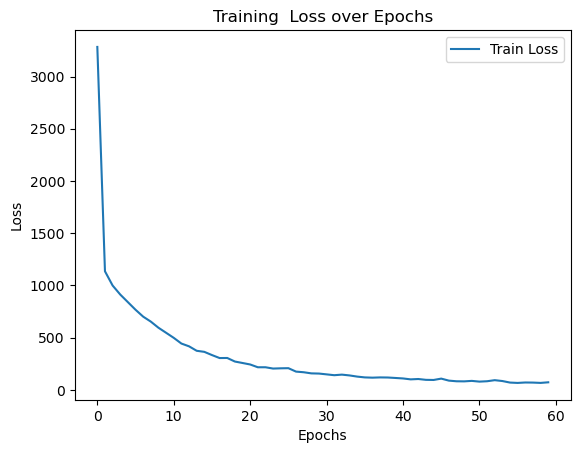

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./csv_files/resnet/carpal/train_history_carpal_test.csv')
#Plotting the training loss
plt.plot(df.epoch[:60], df.loss[:60], label='Train Loss')

#Plotting the validation loss
# plt.plot(df.epoch, df.val_mae, label='Validation Loss')

#Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training  Loss over Epochs')
plt.legend()

In [25]:
def mean_deviation(actual_ages, predicted_ages):
 
    deviations = predicted_ages - actual_ages

    # Calculate mean deviation
    mean_dev = np.mean(deviations)

    return mean_dev

In [14]:
prediction = model.predict(X_val_carpal)


38/38 [==============================] - 3s 90ms/step


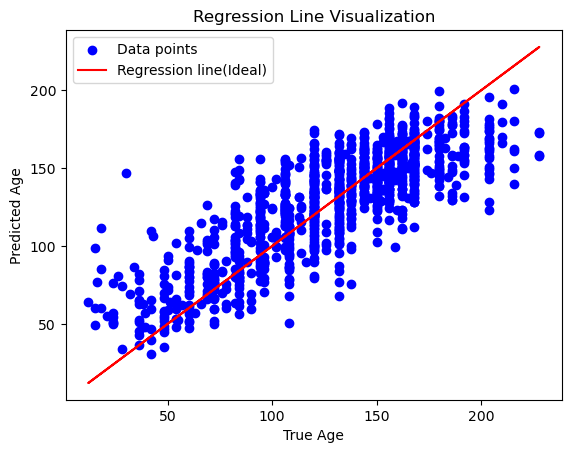

In [15]:

plt.scatter(y_val,prediction,color='blue', label='Data points')
plt.plot(y_val,y_val,color='red',label='Regression line(Ideal)')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Regression Line Visualization')
plt.legend()
plt.show()

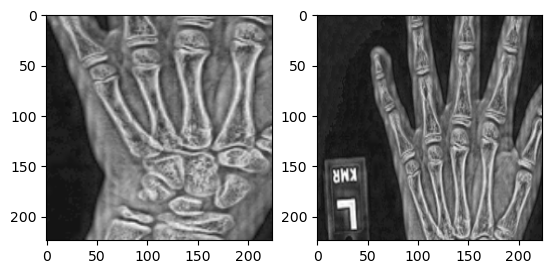

48


In [42]:
import matplotlib.pyplot as plt

fig , (ax1, ax2) = plt.subplots(1,2)
i = 48
ax1.imshow(X_val_carpal[i])
ax2.imshow(X_val_metacarpal[i])
plt.show()
print(list(y_val).index(228))

In [25]:
len(y_val)

1189

In [68]:
model_comb.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                             

In [11]:
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply, Dropout

x = Concatenate()([model_carpal.layers[-2].output, model_carpal.layers[-2].output])

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1)(x)


model_comb = Model(inputs=(model_carpal.input, model_metacarpal.input), outputs=predictions)

In [12]:
from keras.optimizers import Adam
optim = Adam(
    learning_rate = 0.0001,
    beta_1 = 0.9,
    beta_2 = 0.999,
)
model_comb.compile(optimizer=optim, loss='mean_squared_error', metrics=['mae'])


In [13]:
for layer in model_comb.layers[:-5]:
    layer.trainable = False

In [14]:
history_comb = model_comb.fit(
    (X_train_carpal[:4000], X_train_metacarpal[:4000]), y_train[:4000],
    epochs=10,
    batch_size=16,
    validation_data=((X_val_carpal, X_val_metacarpal), y_val),
    callbacks=callbacks_list
)

Epoch 1/10
250/250 [==============================] - 70s 223ms/step - loss: 1080.9423 - mae: 25.4836 - val_loss: 2012.1488 - val_mae: 36.3148
Epoch 2/10
250/250 [==============================] - 54s 215ms/step - loss: 804.6893 - mae: 22.5276 - val_loss: 1561.6251 - val_mae: 31.1992
Epoch 3/10
250/250 [==============================] - 54s 215ms/step - loss: 788.0673 - mae: 22.2032 - val_loss: 1911.1678 - val_mae: 33.1941
Epoch 4/10
250/250 [==============================] - 54s 215ms/step - loss: 723.5108 - mae: 21.1405 - val_loss: 3843.1472 - val_mae: 52.2836
Epoch 5/10
250/250 [==============================] - 54s 215ms/step - loss: 711.6443 - mae: 20.9438 - val_loss: 2559.3845 - val_mae: 43.0835
Epoch 6/10
250/250 [==============================] - 54s 215ms/step - loss: 613.1456 - mae: 19.5829 - val_loss: 1696.9044 - val_mae: 30.7295
Epoch 7/10
250/250 [==============================] - 54s 215ms/step - loss: 574.7513 - mae: 18.9572 - val_loss: 1697.2861 - val_mae: 33.4911
Epoch

In [26]:
predictions = model_comb.predict((X_train_carpal[:4000], X_train_metacarpal[:4000]))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

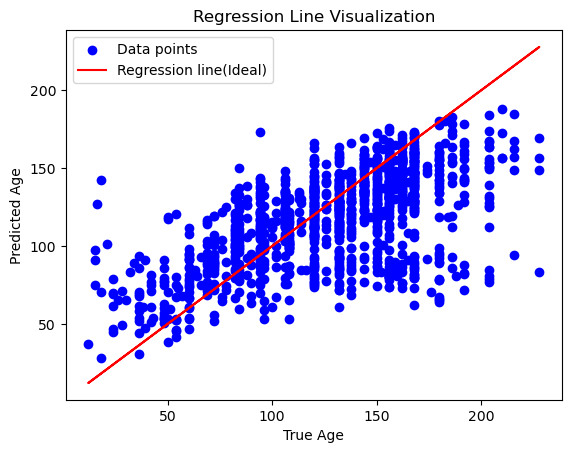

In [19]:

plt.scatter(y_val,predictions,color='blue', label='Data points')
plt.plot(y_val,y_val,color='red',label='Regression line(Ideal)')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Regression Line Visualization')
plt.legend()
plt.show()

In [27]:
model_comb.save('./saved_weights/combined_test_weights.h5')